In [1]:
import json
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tqdm import tqdm
import random
import numpy as np

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
merchant_id = '11167ECFF94860EA'

In [4]:
file = '/data/predict/'+merchant_id+'/'+merchant_id+'_logs.json'

In [5]:
users = {}
with open(file, encoding='utf8') as f:
    for line in tqdm(f):
        data = json.loads(line)
        if data['visitor_id'] not in users:
            users[data['visitor_id']] = []
        for prod_idx in data['viewed_products']:
            try:
                users[data['visitor_id']].append(prod_idx)
            except ValueError: 
                print('Sktrain_labelsiped ' + prod_idx)

59810it [00:00, 114799.96it/s]


In [6]:
users_lens = list(map(lambda x: len(x), users.values()))

In [7]:
print(len(users.keys()))

15710


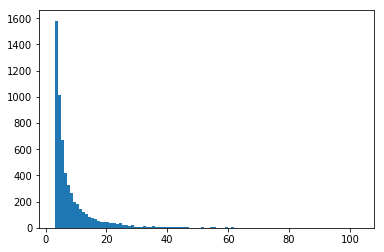

In [8]:
d = plt.hist(users_lens, bins=100, range=(3, 103))

In [9]:
products = {}
for u in users.values():
    for pid in u:
        products[pid] = 1
product_idxs = products.keys()
product_ids = {v: k for k, v in enumerate(product_idxs)}
number_of_classes = len(product_idxs)

In [10]:
print(number_of_classes)

2043


In [11]:
def dedup(seq):
    seen = set()
    seen_add = seen.add

    return [x for x in seq if not (x in seen or seen_add(x))]


users_with_product_idxs = {}
for uid,products in users.items():
    ids = dedup(list(map(lambda x: product_ids[x], products)))
    if len(ids) > 1:
        users_with_product_idxs[uid] = ids
    
del users

In [12]:
raw_data = []
raw_abels  = []
for uid,products in tqdm(users_with_product_idxs.items()):
    if(len(products) > 5):
        for i in range(len(products) - 6):
            if(random.random() < 1):
                for j in range(i+6,len(products)):
                    raw_data.append(np.array(products[i:(i+5)]))
                    raw_abels.append(np.array(products[j]))

100%|██████████| 7651/7651 [00:00<00:00, 42473.70it/s]


In [13]:
data_np = np.stack(raw_data)
labels_np = np.expand_dims(np.stack(raw_abels), axis=1)

In [14]:
from sklearn.model_selection import train_test_split
train_data, valid_data, train_labels, valid_labels  = train_test_split(data_np , labels_np, test_size=0.10, shuffle=True)

In [15]:
import bcolz
emb_weights = bcolz.open('/data/predict/'+merchant_id+'/'+merchant_id+'_embedding')[:]

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, CuDNNGRU, CuDNNLSTM, Dense, Dropout, TimeDistributed,Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.optimizers import Nadam


n_hidden = 100

model=Sequential([
        Embedding(number_of_classes, n_hidden, batch_input_shape=(None,None), weights=emb_weights, trainable=False),
        BatchNormalization(),
        #CuDNNGRU(4*n_hidden, input_shape=(None,n_hidden),return_sequences=True),
        CuDNNLSTM(4*n_hidden, input_shape=(None,n_hidden),return_sequences=True),
        Dropout(0.2),
        #CuDNNGRU(4*n_hidden),
        CuDNNLSTM(4*n_hidden),
        Dropout(0.2),
        #Dense(n_hidden, activation='relu'),
        Dense(number_of_classes, activation='softmax')
    ])

In [18]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy','sparse_top_k_categorical_accuracy'], optimizer=Nadam())

In [19]:
from keras.callbacks import ModelCheckpoint
filepath='/data/predict/'+merchant_id+'/'+merchant_id+'_fixed_length_future_lstm_model-{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

In [20]:
import csv
with open('/data/predict/'+merchant_id+'/'+merchant_id+'_fixed_length_future_lstm_model_id_map.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile)
    for line in product_idxs:
        spamwriter.writerow([line])

In [21]:
model.fit(
    train_data, 
    train_labels,
    validation_data=(valid_data,valid_labels), 
    batch_size=256, 
    epochs=6, 
    #callbacks = [checkpoint],
    shuffle=True)

Train on 47037 samples, validate on 5227 samples
Epoch 1/6
47037/47037 [==============================] - 5s 99us/step - loss: 6.5513 - sparse_categorical_accuracy: 0.0117 - sparse_top_k_categorical_accuracy: 0.0518 - val_loss: 5.9172 - val_sparse_categorical_accuracy: 0.0210 - val_sparse_top_k_categorical_accuracy: 0.0872
Epoch 2/6
47037/47037 [==============================] - 2s 43us/step - loss: 4.8486 - sparse_categorical_accuracy: 0.0373 - sparse_top_k_categorical_accuracy: 0.1871 - val_loss: 4.6464 - val_sparse_categorical_accuracy: 0.0260 - val_sparse_top_k_categorical_accuracy: 0.1716
Epoch 3/6
47037/47037 [==============================] - 2s 42us/step - loss: 3.9927 - sparse_categorical_accuracy: 0.0620 - sparse_top_k_categorical_accuracy: 0.3000 - val_loss: 4.2366 - val_sparse_categorical_accuracy: 0.0251 - val_sparse_top_k_categorical_accuracy: 0.2074
Epoch 4/6
47037/47037 [==============================] - 2s 43us/step - loss: 3.6018 - sparse_categorical_accuracy: 0.0766 

## Eye ball validation

In [22]:
import csv

In [23]:
merchant_id

'11167ECFF94860EA'

In [24]:
product_map = {}
with open('/data/predict/'+merchant_id+'/'+merchant_id+'_catalog.csv', 'r', encoding='utf8') as csvfile:
    spamreader = csv.reader(csvfile)
    header = next(spamreader)
    item_id = header.index('item')
    image_url = header.index('image')
    title = header.index('title')
    link = header.index('link')
    
    for row in spamreader:
        product_map[row[item_id]] = [row[image_url], row[title], row[link]]

In [25]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [28]:
from IPython.core.display import display as core_display
from IPython.core.display import HTML 

def product_to_url(product):
    try:
        
        return [product] + product_map[list(product_idxs)[product]] + [list(product_idxs)[product]]
    except KeyError:
        return [product,'http://www.lackuna.com/wp-content/themes/fearless/images/missing-image-640x360.png','UNKNOWN','', '']

    
def display_sessions(sessions):
    predictions = model.predict(np.array(sessions))
    for i in range(len(sessions)):
        #print(predictions[i])
        display_session(sessions[i])
    
def display_session(session, predictions = None):
    products = list(map(product_to_url, session))
    if predictions is None:
        predictions = model.predict([session])
        
    html = '<table>'
    html += '<tr>'
    seen = set()
    for i,product in enumerate(products):

        html += '<td style="text-align:center;width:100px">'
        html += '<img src="' + product[1] + '" width="100"><br/>' 
        html += '<a href="'+str(product[3])+'">' + str(product[4]) + '</a></br>' + str(product[2])
        html += '</td>'
        
        seen.add(product[0])
    
    html += '<td style="background-color:black;"></td>'
    top_idx = list(np.argsort(predictions[0])[::-1])
        
    j = 0
    for pred in top_idx:
        if pred in seen:
            continue   
                
        pred_data = product_to_url(pred)
        if pred_data[2] == 'UNKNOWN':
            continue 
            
        html += '<td style="text-align:center;width:100px">'
        html += '<img src="' + pred_data[1] + '" width="100"><br/>' 
        html += '<a href="'+str(pred_data[3]) + '">' +str(pred_data[4]) + '</a></br>' + str(pred_data[2]) + '</td>'
        j+=1
        if j >= 5:
            break
                
    html += '</tr>'
    html += '</table>'

    core_display(HTML(html))

display_session(random.choice(valid_data))

2041507Damen-Pullover in gestrickter Melange-Optik,2041503Damen-Pullover mit modischem Strickmuster,2041504Damen-Pullover mit trendigen Seitenschlitzen,2041972Damen-Strickjacke mit großen Knöpfen,2041826Damen-Thermo-Socken mit schickem Muster,,2042455Damen-Strickjacke mit Lurexfaden,2042220Damen-Shirt mit dekorativem Ausschnitt,2042534Damen-Pullover mit Ajour-Einsätzen,2041974Damen-Pullover mit doppellagigem Design,2042452Damen-Rollkragen-Pullover mit spannendem Muster


### Do we make different predictions based on history?

In [29]:
grouped_by_last_item = {}
for session in valid_data:
    if session[-1] not in grouped_by_last_item:
        grouped_by_last_item[session[-1]] = []
    grouped_by_last_item[session[-1]].append(session)

In [52]:
gr = random.choice(list(grouped_by_last_item.keys()))
display_sessions(grouped_by_last_item[gr])

2043559Damen-2-in-1-Allwetterjacke,2041507Damen-Pullover in gestrickter Melange-Optik,2043560Damen-Daunenjacke mit Kontrast-Futter,2041504Damen-Pullover mit trendigen Seitenschlitzen,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,"2040457Damen-Rioslip mit Spitzen-Einsatz, 2er Pack",2042550Damen-Strickjacke mit Glitzer-Effekten,2039970Jungen-Jacke mit verschiedenen Applikationen,"2039725Damen-Feinstrumpfhose mit Rauten-Muster, 80 DEN",2041826Damen-Thermo-Socken mit schickem Muster


2041507Damen-Pullover in gestrickter Melange-Optik,2041504Damen-Pullover mit trendigen Seitenschlitzen,2041503Damen-Pullover mit modischem Strickmuster,2043560Damen-Daunenjacke mit Kontrast-Futter,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2042455Damen-Strickjacke mit Lurexfaden,2042220Damen-Shirt mit dekorativem Ausschnitt,2042534Damen-Pullover mit Ajour-Einsätzen,2041974Damen-Pullover mit doppellagigem Design,2042452Damen-Rollkragen-Pullover mit spannendem Muster


2043309Damen-Carmenshirt mit trendigem Muster,2041507Damen-Pullover in gestrickter Melange-Optik,UNKNOWN,2042220Damen-Shirt mit dekorativem Ausschnitt,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2042803Damen-Bluse mit trendigem Karomuster,2043236Damen-Shirt mit Spitze am Ausschnitt,2041480Damen-Pullover mit Streifenmuster,2042452Damen-Rollkragen-Pullover mit spannendem Muster,"2041126Damen-Stoffhose in Bengalin-Qualität, große Größen"


2043233Damen-Shirt in verschiedenen Designs,2042220Damen-Shirt mit dekorativem Ausschnitt,2042460Damen-Shirt mit künstlerischem Muster,2042459Damen-Shirt mit Rollkragen,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2042823Damen-Shirt mit modernem Muster,2042073Herren-Jeans mit modischen Waschungen,2043213Damen-Shirt mit hohem Baumwoll-Anteil,2042541Damen-Strickjacke mit Spitzeneinsatz am Rücken,"2043413Deko-Figur, ca. 40cm"


2043309Damen-Carmenshirt mit trendigem Muster,2041507Damen-Pullover in gestrickter Melange-Optik,UNKNOWN,2042220Damen-Shirt mit dekorativem Ausschnitt,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2042803Damen-Bluse mit trendigem Karomuster,2043236Damen-Shirt mit Spitze am Ausschnitt,2041480Damen-Pullover mit Streifenmuster,2042452Damen-Rollkragen-Pullover mit spannendem Muster,"2041126Damen-Stoffhose in Bengalin-Qualität, große Größen"


2041507Damen-Pullover in gestrickter Melange-Optik,2041504Damen-Pullover mit trendigen Seitenschlitzen,2042902Damen-Shirt mit Bindebändern am Ausschnitt,2041481Damen-Chenille-Pullover mit Rollkragen,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2042455Damen-Strickjacke mit Lurexfaden,2042220Damen-Shirt mit dekorativem Ausschnitt,2042534Damen-Pullover mit Ajour-Einsätzen,2041974Damen-Pullover mit doppellagigem Design,2042452Damen-Rollkragen-Pullover mit spannendem Muster


2041507Damen-Pullover in gestrickter Melange-Optik,2041504Damen-Pullover mit trendigen Seitenschlitzen,2041503Damen-Pullover mit modischem Strickmuster,2043560Damen-Daunenjacke mit Kontrast-Futter,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2042455Damen-Strickjacke mit Lurexfaden,2042220Damen-Shirt mit dekorativem Ausschnitt,2042534Damen-Pullover mit Ajour-Einsätzen,2041974Damen-Pullover mit doppellagigem Design,2042452Damen-Rollkragen-Pullover mit spannendem Muster


2041508Damen-Chenille-Strickjacke mit aufgesetzten Taschen,2043287Damen-Rock in Stufen-Optik,2043286Damen-Jeans mit Stickerei und Glitzersteinchen,2041481Damen-Chenille-Pullover mit Rollkragen,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2041507Damen-Pullover in gestrickter Melange-Optik,2042539Damen-Pullover mit Rauten-Struktur und Pailletten,2042803Damen-Bluse mit trendigem Karomuster,2041973Damen-Pullover mit modernem Saum,2042526Damen-Pullover in Ripp-Optik


2042459Damen-Shirt mit Rollkragen,2043298Damen-Shirt mit Leo-Muster und Spitze,2043309Damen-Carmenshirt mit trendigem Muster,2043310Damen-Carmenshirt mit elastischem Saum,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2042803Damen-Bluse mit trendigem Karomuster,2042325Polycotton-Bettwäsche mit modernem Muster,2041507Damen-Pullover in gestrickter Melange-Optik,"2043519Papier-Lampion-Lichterkette, ca. 165cm",2041787Herren-Sweatshirt mit glänzendem Frontaufdruck


2041504Damen-Pullover mit trendigen Seitenschlitzen,2041972Damen-Strickjacke mit großen Knöpfen,2043309Damen-Carmenshirt mit trendigem Muster,2043310Damen-Carmenshirt mit elastischem Saum,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,"2040457Damen-Rioslip mit Spitzen-Einsatz, 2er Pack",2042539Damen-Pullover mit Rauten-Struktur und Pailletten,2042803Damen-Bluse mit trendigem Karomuster,2042933Damen-Poncho mit Zierfransen,"1677284Damen-Unterhemd, 2er Pack"


2041508Damen-Chenille-Strickjacke mit aufgesetzten Taschen,2043287Damen-Rock in Stufen-Optik,2043286Damen-Jeans mit Stickerei und Glitzersteinchen,2041481Damen-Chenille-Pullover mit Rollkragen,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2041507Damen-Pullover in gestrickter Melange-Optik,2042539Damen-Pullover mit Rauten-Struktur und Pailletten,2042803Damen-Bluse mit trendigem Karomuster,2041973Damen-Pullover mit modernem Saum,2042526Damen-Pullover in Ripp-Optik


2041507Damen-Pullover in gestrickter Melange-Optik,2041500Damen-Pullover mit tollem Strickmuster,2043560Damen-Daunenjacke mit Kontrast-Futter,2043310Damen-Carmenshirt mit elastischem Saum,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2042455Damen-Strickjacke mit Lurexfaden,2042220Damen-Shirt mit dekorativem Ausschnitt,2041504Damen-Pullover mit trendigen Seitenschlitzen,2042534Damen-Pullover mit Ajour-Einsätzen,2041974Damen-Pullover mit doppellagigem Design


2040964Damen-Steppjacke in Glanz-Optik,2040955Damen-Steppjacke mit Kontrast-Innenfutter,2043309Damen-Carmenshirt mit trendigem Muster,2048693Damen-Shirt mit modernem Blumenmuster,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2043559Damen-2-in-1-Allwetterjacke,2041507Damen-Pullover in gestrickter Melange-Optik,2040961Damen-Steppjacke mit Schmucksteinchen,2040960Damen-Parka mit Kunstfell,2045417Damen-Pullover mit Schmucksteinchen


2040964Damen-Steppjacke in Glanz-Optik,2040955Damen-Steppjacke mit Kontrast-Innenfutter,2043309Damen-Carmenshirt mit trendigem Muster,2048693Damen-Shirt mit modernem Blumenmuster,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2043559Damen-2-in-1-Allwetterjacke,2041507Damen-Pullover in gestrickter Melange-Optik,2040961Damen-Steppjacke mit Schmucksteinchen,2040960Damen-Parka mit Kunstfell,2045417Damen-Pullover mit Schmucksteinchen


2042453Damen-Rollkragen-Pullover mit schicken Bündchen,2042848Damen-Sweatshirt in trendiger Melange-Optik,2042849Damen-Sweatshirt mit Bindebändern,2043310Damen-Carmenshirt mit elastischem Saum,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2042803Damen-Bluse mit trendigem Karomuster,2042539Damen-Pullover mit Rauten-Struktur und Pailletten,"1677284Damen-Unterhemd, 2er Pack","2040457Damen-Rioslip mit Spitzen-Einsatz, 2er Pack","2041560Bügelbilder mit verschiedenen Motiven, 7-teilig"


2043559Damen-2-in-1-Allwetterjacke,2041504Damen-Pullover mit trendigen Seitenschlitzen,2041500Damen-Pullover mit tollem Strickmuster,2043560Damen-Daunenjacke mit Kontrast-Futter,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2041507Damen-Pullover in gestrickter Melange-Optik,"2040457Damen-Rioslip mit Spitzen-Einsatz, 2er Pack",2042550Damen-Strickjacke mit Glitzer-Effekten,2039970Jungen-Jacke mit verschiedenen Applikationen,"2039725Damen-Feinstrumpfhose mit Rauten-Muster, 80 DEN"


2041507Damen-Pullover in gestrickter Melange-Optik,2041504Damen-Pullover mit trendigen Seitenschlitzen,2041503Damen-Pullover mit modischem Strickmuster,2043560Damen-Daunenjacke mit Kontrast-Futter,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2042455Damen-Strickjacke mit Lurexfaden,2042220Damen-Shirt mit dekorativem Ausschnitt,2042534Damen-Pullover mit Ajour-Einsätzen,2041974Damen-Pullover mit doppellagigem Design,2042452Damen-Rollkragen-Pullover mit spannendem Muster


2041504Damen-Pullover mit trendigen Seitenschlitzen,2041972Damen-Strickjacke mit großen Knöpfen,2043309Damen-Carmenshirt mit trendigem Muster,2043310Damen-Carmenshirt mit elastischem Saum,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,"2040457Damen-Rioslip mit Spitzen-Einsatz, 2er Pack",2042539Damen-Pullover mit Rauten-Struktur und Pailletten,2042803Damen-Bluse mit trendigem Karomuster,2042933Damen-Poncho mit Zierfransen,"1677284Damen-Unterhemd, 2er Pack"


2041508Damen-Chenille-Strickjacke mit aufgesetzten Taschen,2043287Damen-Rock in Stufen-Optik,2043286Damen-Jeans mit Stickerei und Glitzersteinchen,2041481Damen-Chenille-Pullover mit Rollkragen,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2041507Damen-Pullover in gestrickter Melange-Optik,2042539Damen-Pullover mit Rauten-Struktur und Pailletten,2042803Damen-Bluse mit trendigem Karomuster,2041973Damen-Pullover mit modernem Saum,2042526Damen-Pullover in Ripp-Optik


2040373Damen-Steppjacke mit 2-Wege-Reißverschluss,UNKNOWN,2043659Damen-Jacquardpullover aus flauschigem Material,2042849Damen-Sweatshirt mit Bindebändern,2042807Damen-Sweatshirt mit Kordelzug und Trend-Muster,,2040371Damen-Anorak in Glanz-Optik,2040196Damen-Anorak mit Fleece-Innenfutter,2040374Damen-Anorak mit schicken Knöpfe,2043298Damen-Shirt mit Leo-Muster und Spitze,2041507Damen-Pullover in gestrickter Melange-Optik
